In [1]:
import ppptm as gptm
import optax
import liesel.goose as gs
from liesel_ptm.util.plots import plot_loss, plot_param_history

In [2]:
def opt1():
    # Define the learning rate scheduler
    scheduler = optax.cosine_decay_schedule(init_value=0.01, decay_steps=2000)

    # Define the AdamW optimizer with weight decay
    adamw_optimizer = optax.adamw(learning_rate=scheduler, weight_decay=1e-4)

    gradient_clipping = optax.clip_by_global_norm(1.0)

    # Combine them using optax.chain
    combined_optimizer = optax.chain(gradient_clipping, adamw_optimizer)
    return combined_optimizer

In [3]:
data = gptm.load_americas()

In [4]:
locs = gptm.LocationVars.new_from(data.locs, n_subset=256)
model = gptm.Model.new_HG(data.obs[:, locs.locs.ordering], locs)

In [5]:
val = model.coef.latent_var.value
Kuu = model.coef.Kuu.value
Kdu = model.coef.Kdu.value
amplitude = model.coef.amplitude.value
model.coef.value_node.function(val, Kuu, Kdu, amplitude)

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
y = model.response.value
coef = model.coef.value
model.dist_node.bspline.dot_and_deriv(y, coef)

(Array([[-15.090757, -18.461143, -20.928452, ..., -19.609343, -20.338194,
         -19.781717],
        [-15.476009, -17.715708, -17.620827, ..., -23.02585 , -23.022346,
         -22.231665],
        [-16.874311, -17.427696, -22.122362, ..., -19.796724, -18.245321,
         -17.58356 ],
        ...,
        [-15.642825, -20.573463, -23.025671, ..., -17.020674, -18.817497,
         -18.935026],
        [-15.246725, -19.660006, -23.021114, ..., -19.078075, -19.704788,
         -19.519487],
        [-16.552776, -18.059994, -18.895437, ..., -18.447441, -19.626926,
         -19.860598]], dtype=float32),
 Array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))

In [9]:
result = model.fit(
    stopper=gs.Stopper(max_iter=2_000, patience=30),
    optimizer=opt1(),
    progress_bar=True,
)

Training loss: 427676.656, Validation loss: 427676.688:  21%|██        | 414/2000 [00:19<01:08, 23.27it/s]

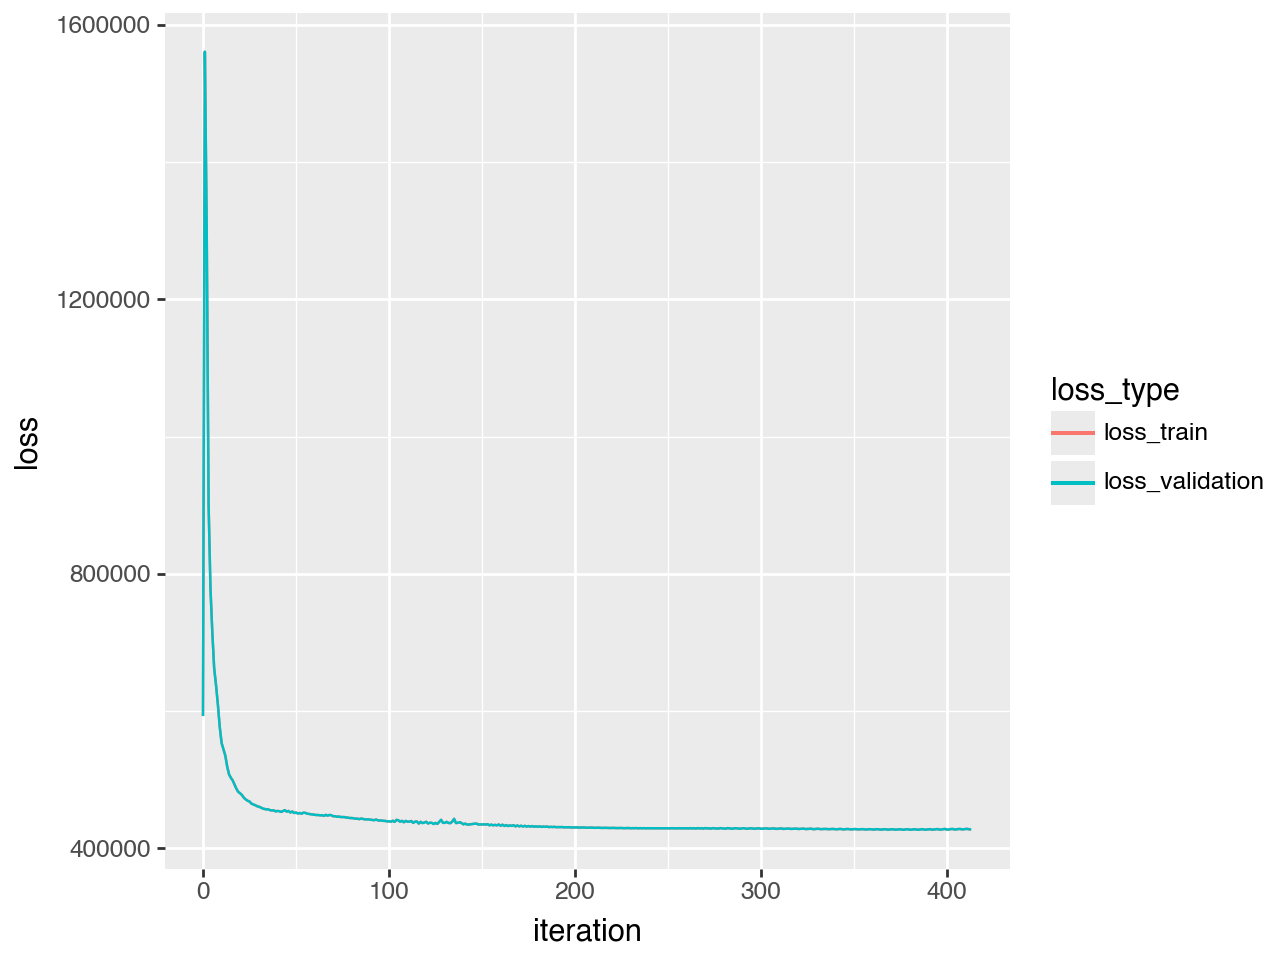

Training loss: 427676.656, Validation loss: 427676.688:  21%|██        | 414/2000 [00:30<01:08, 23.27it/s]

In [10]:
plot_loss(result)

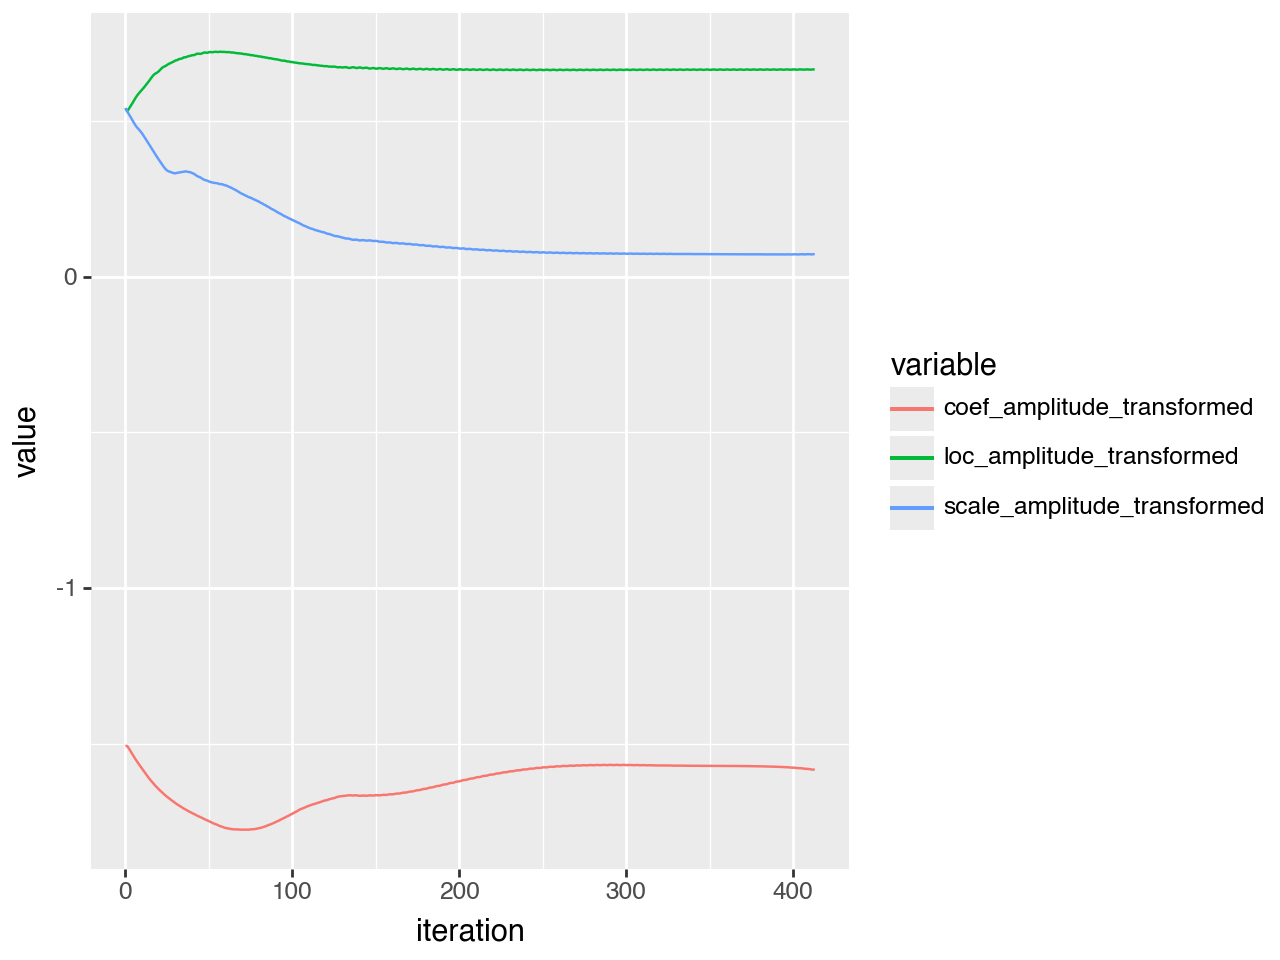

In [11]:
d = {k: v for k, v in result.history["position"].items() if "amplitude" in k}
plot_param_history(d)

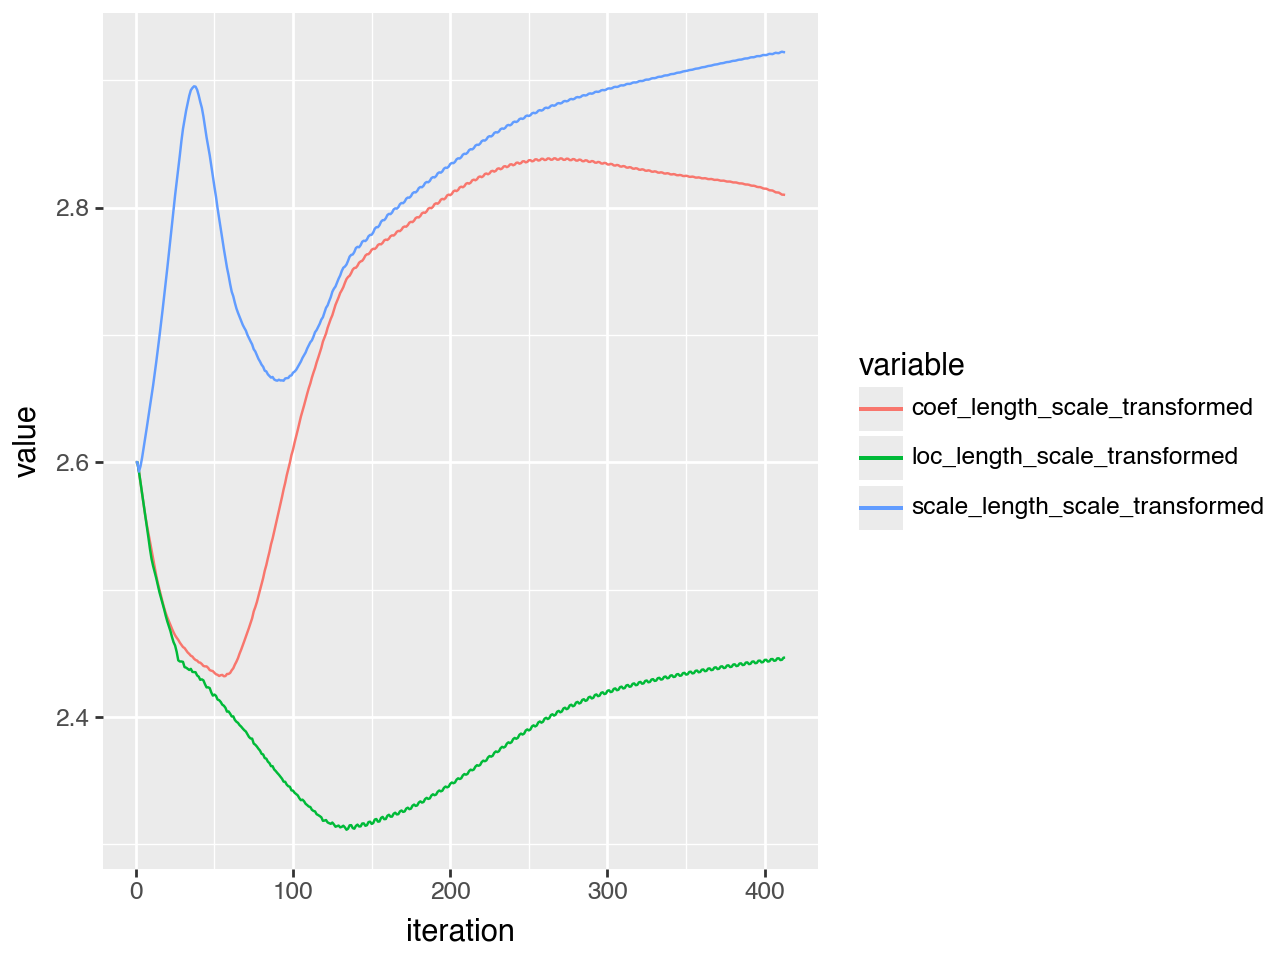

In [12]:
d = {k: v for k, v in result.history["position"].items() if "length_scale" in k}
plot_param_history(d)

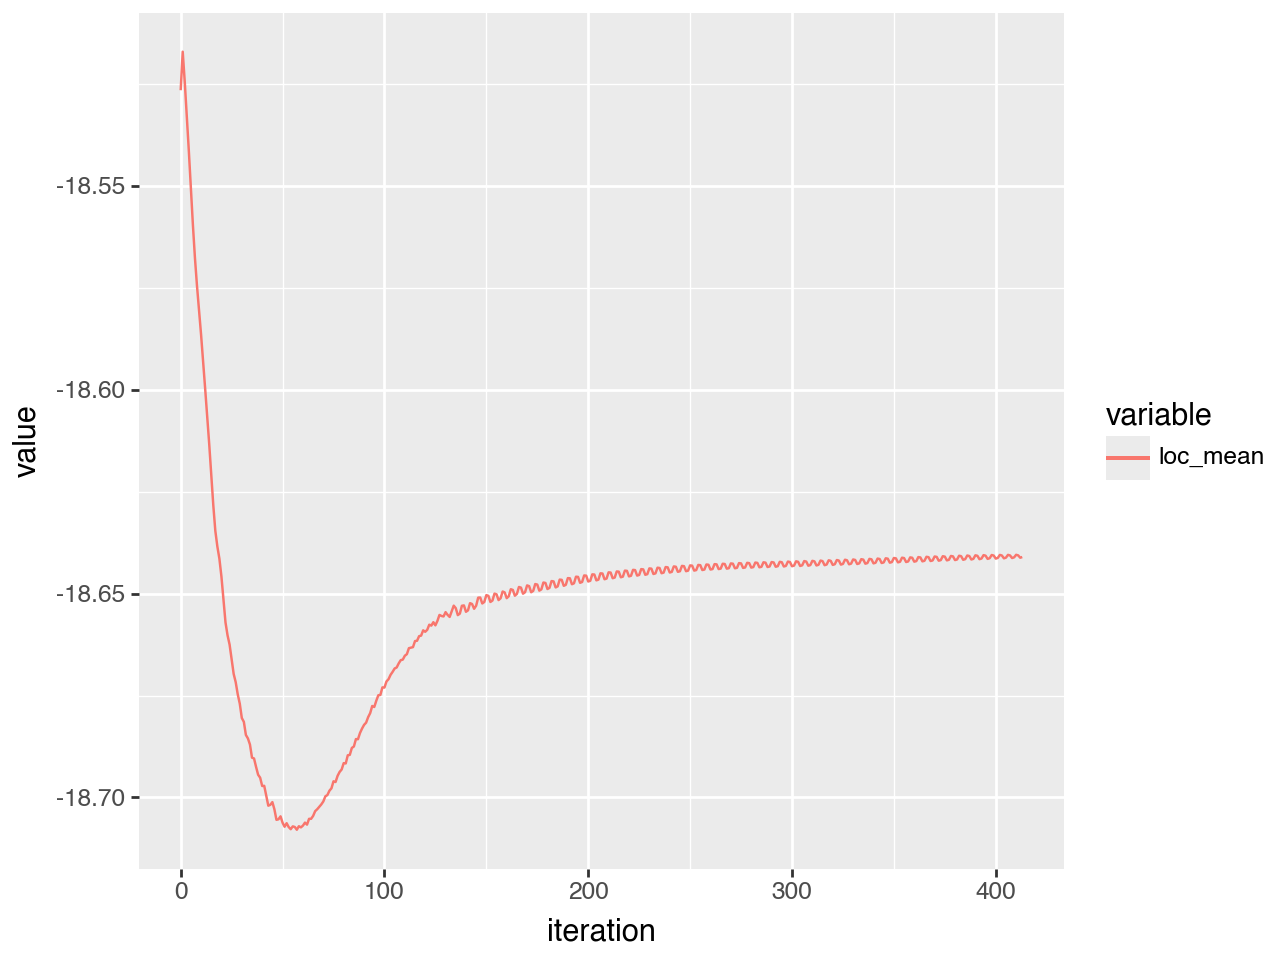

In [13]:
d = {k: v for k, v in result.history["position"].items() if "loc_mean" in k}
plot_param_history(d)

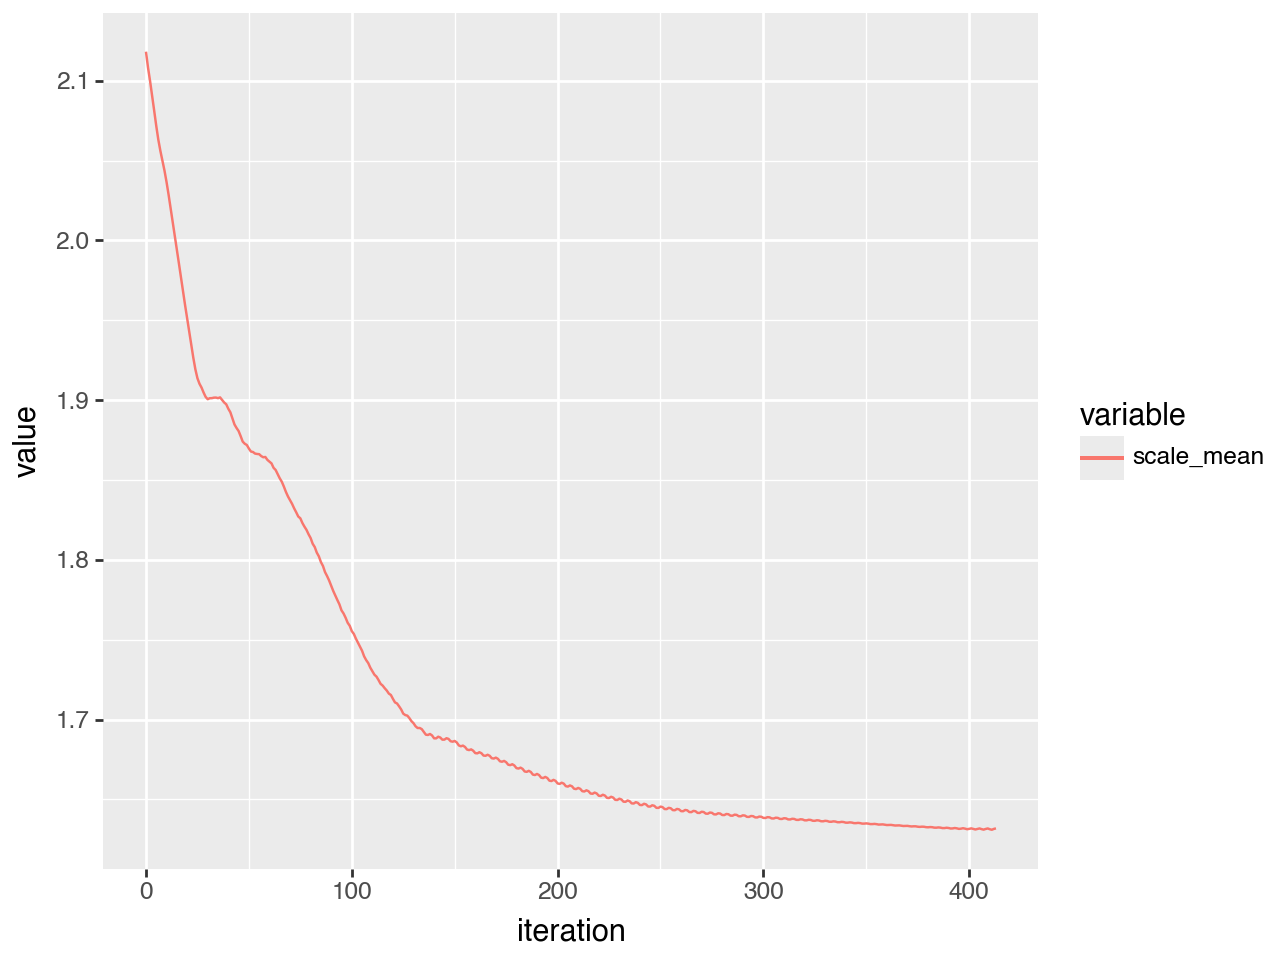

In [14]:
d = {k: v for k, v in result.history["position"].items() if "scale_mean" in k}
plot_param_history(d)

In [15]:
df = gptm.long_df_multiple(
    locs.locs.ordered,
    mu=model.graph.vars["loc"].value,
    sigma=model.graph.vars["scale"].value,
)

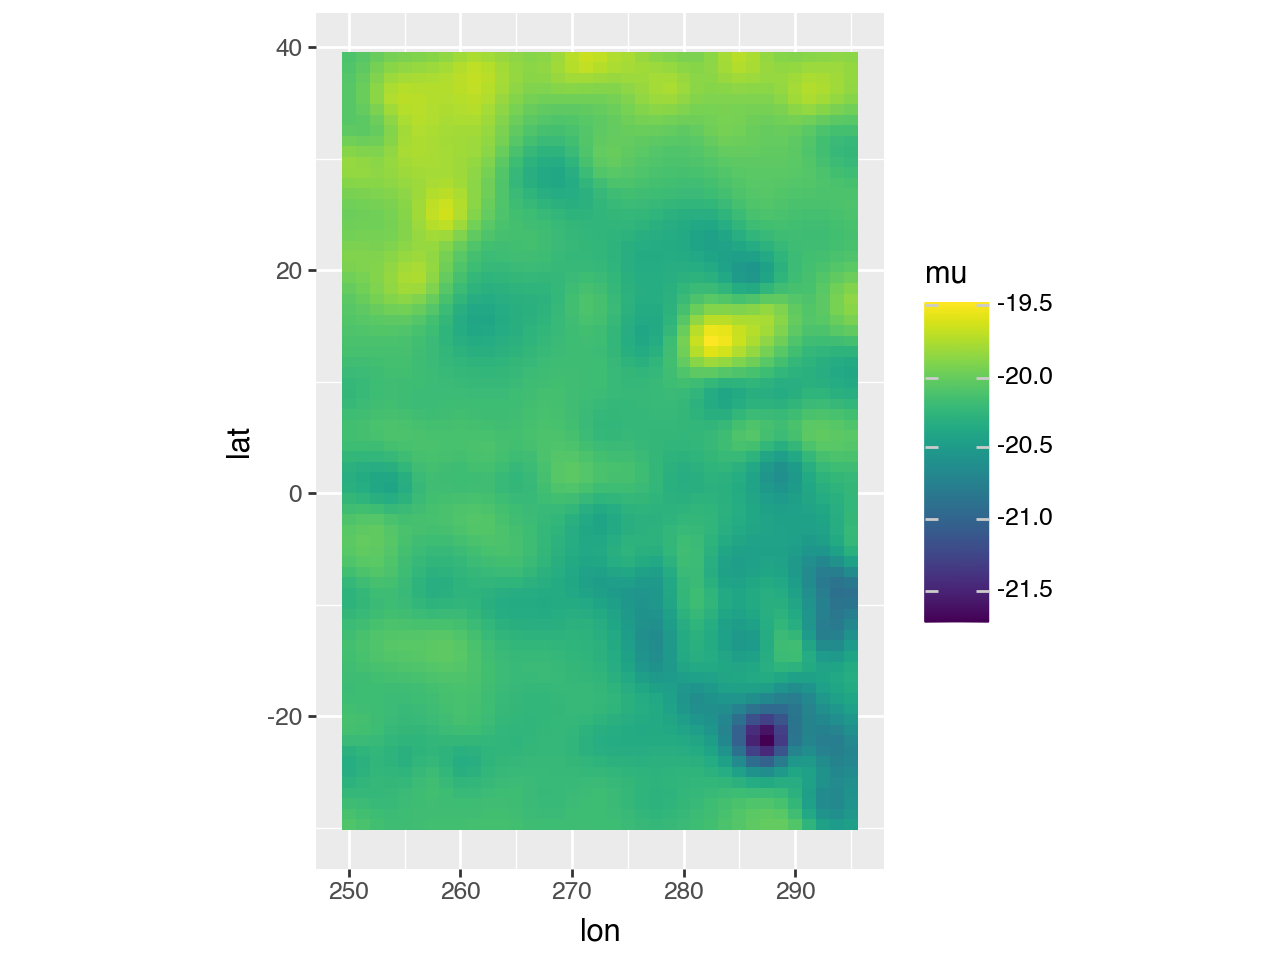

In [16]:
gptm.plot_df(df, "mu")

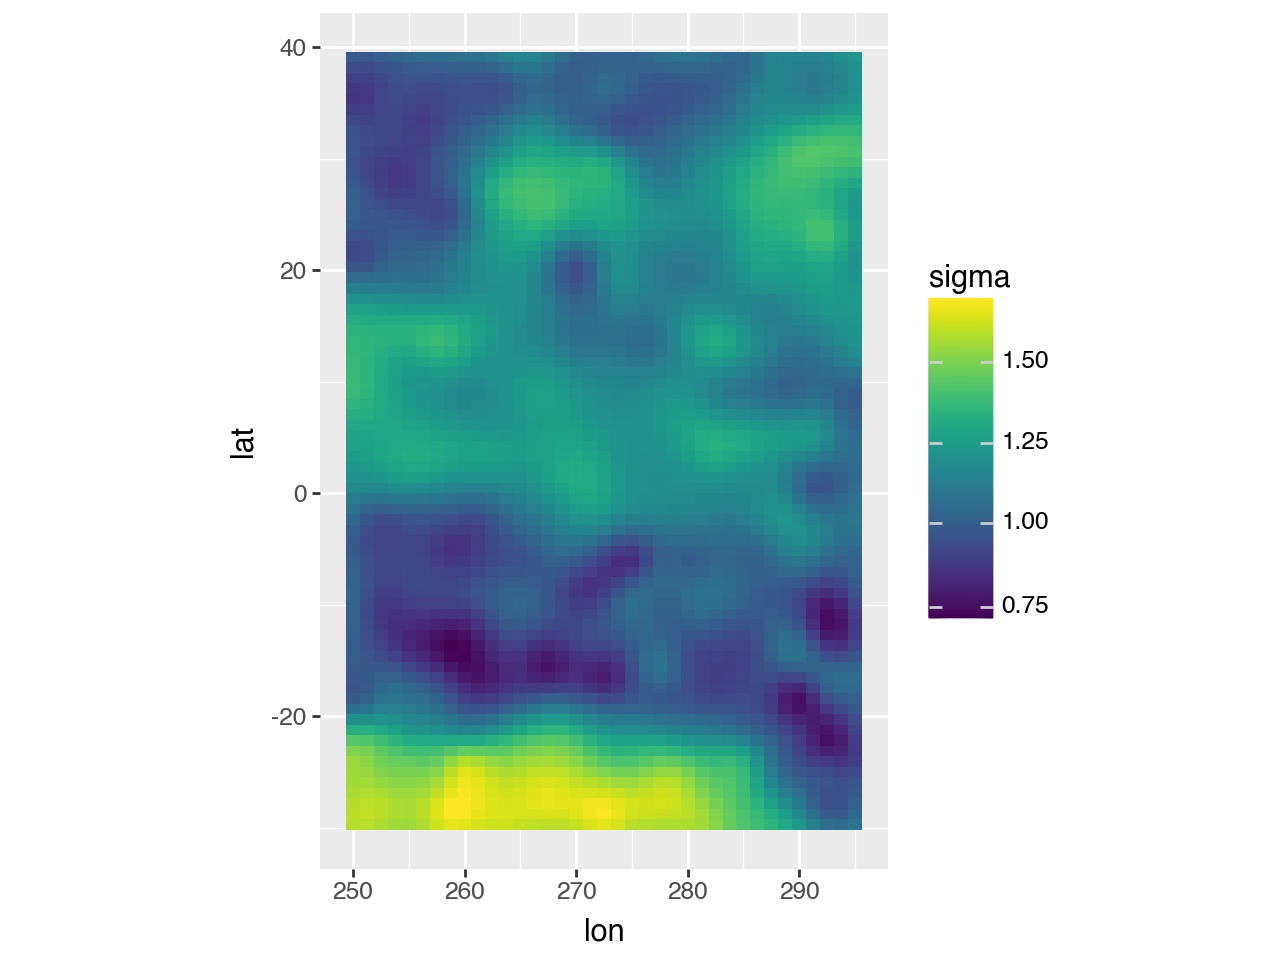

In [17]:
gptm.plot_df(df, "sigma")

In [18]:
model.coef.value.shape

(2738, 40)

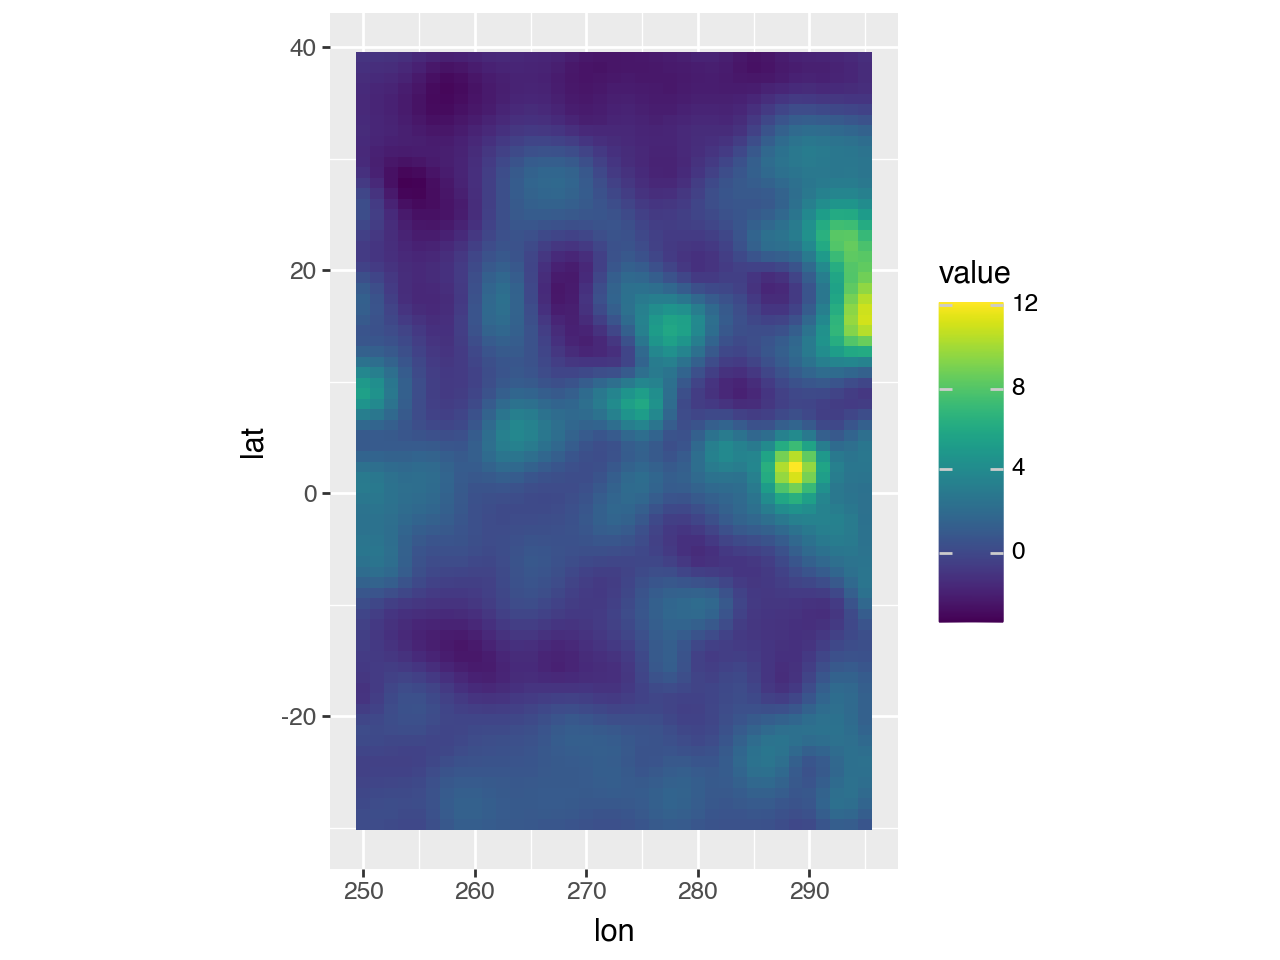

In [21]:
df = gptm.long_df(locs.locs.ordered, model.coef.value.T)
gptm.plot_df(df.query("obs == 20"))

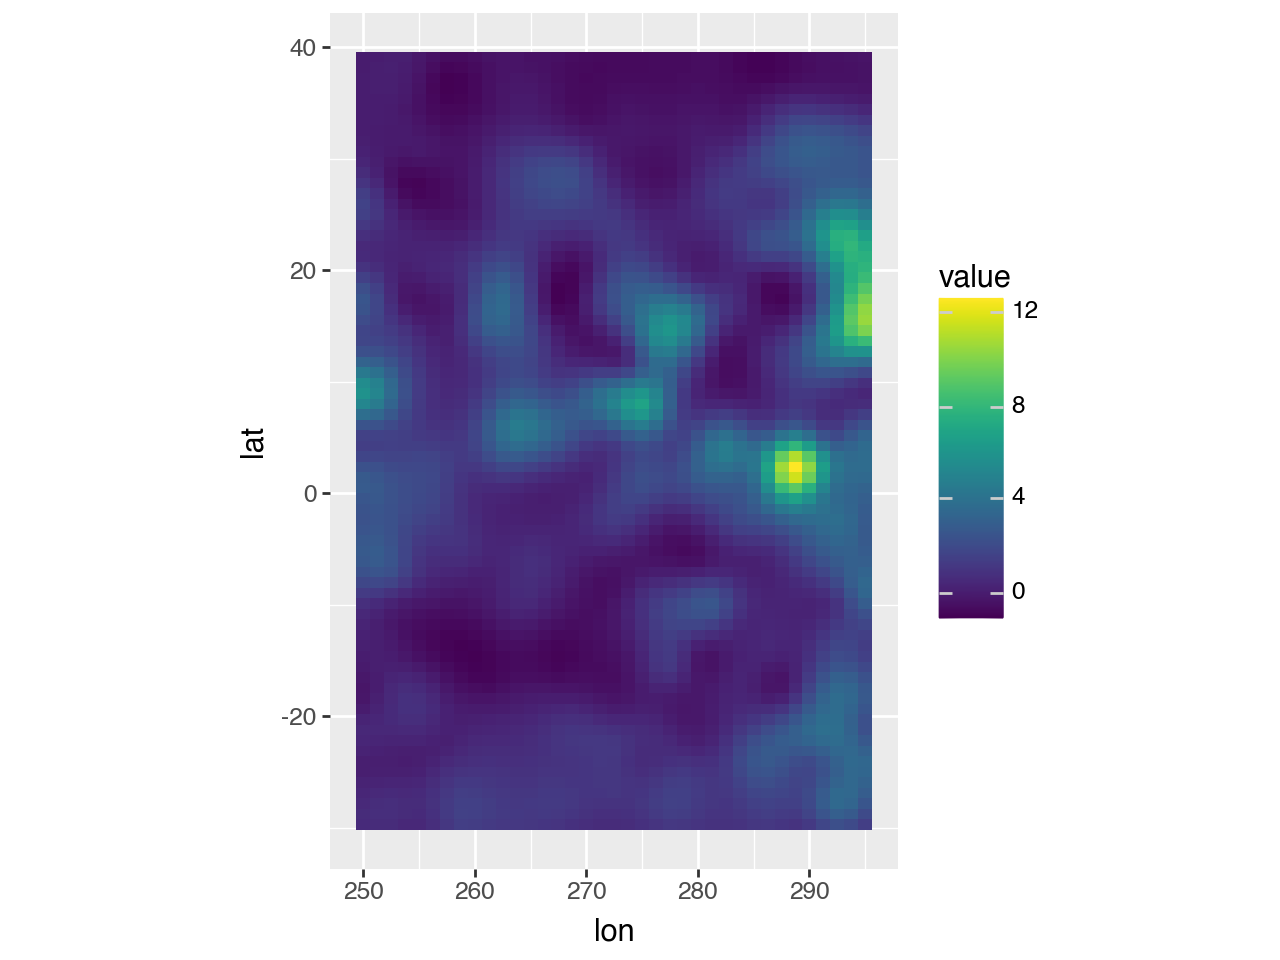

In [22]:
gptm.plot_df(df.query("obs == 30"))